# Phase 2: Visualizing Game States and Spatial Context

In this notebook, we translate raw coordinate data into tactical visualizations. 
The goal is to provide a spatial frame of reference for both tracking and event data.

### Key Objectives:
1.  **Pitch Construction:** Generating a FIFA-standard pitch scaled to meters.
2.  **Event Localization:** Identifying key match events (goals) and visualizing player positioning.
3.  **Team Shape Analysis:** Observing the horizontal and vertical compacteness of teams during different game states.

---

In [37]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
df_home=pd.read_pickle("DATASETS/Cleaned/Home_Tracking_Clean.pkl")
df_away=pd.read_pickle("DATASETS/Cleaned/Away_Tracking_Clean.pkl")
df_events=pd.read_pickle("DATASETS/Cleaned/Event_Tracking_Clean.pkl")
df_stats=pd.read_pickle("DATASETS/Cleaned/Player_Stats_Clean.pkl")


## 1. Pitch Construction
To ensure accuracy, the pitch is drawn using a function that centers the origin $(0,0)$ at the center spot. 
Dimensions are set to **105m x 68m**, matching the scaling applied during the preprocessing phase.

In [52]:
def draw_pitch(figsize=(12, 8), pitch_color='#2e2e2e', line_color='white'):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(pitch_color)
    ax.set_facecolor(pitch_color)

    length, width = 105, 68
    
    # Use ax.plot instead of plt.plot to ensure it stays on this specific canvas
    ax.plot([-length/2, length/2, length/2, -length/2, -length/2], 
             [-width/2, -width/2, width/2, width/2, -width/2], color=line_color, linewidth=2)
    
    ax.plot([0, 0], [-width/2, width/2], color=line_color, linewidth=2)
    center_circle = plt.Circle((0, 0), 9.15, color=line_color, fill=False, linewidth=2)
    ax.add_artist(center_circle)
    ax.scatter(0, 0, color=line_color)

    # Penalty Areas
    ax.plot([-length/2, -length/2+16.5, -length/2+16.5, -length/2], 
             [-20.15, -20.15, 20.15, 20.15], color=line_color, linewidth=2)
    ax.plot([length/2, length/2-16.5, length/2-16.5, length/2], 
             [-20.15, -20.15, 20.15, 20.15], color=line_color, linewidth=2)

    # Six Yard Boxes
    ax.plot([-length/2, -length/2+5.5, -length/2+5.5, -length/2], 
             [-9.16, -9.16, 9.16, 9.16], color=line_color, linewidth=1)
    ax.plot([length/2, length/2-5.5, length/2-5.5, length/2], 
             [-9.16, -9.16, 9.16, 9.16], color=line_color, linewidth=1)

    ax.set_aspect('equal') # Keeps the pitch from looking squashed
    ax.axis('off')
    return fig, ax

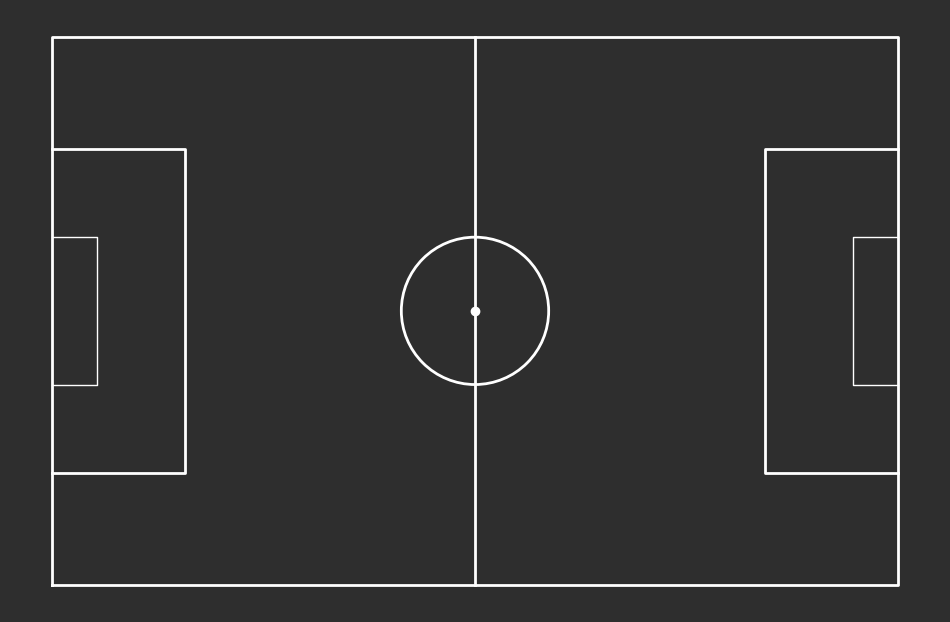

In [53]:
# Test call
fig, ax = draw_pitch()
plt.show()

In [27]:
def get_broadcast_time(frame, df_events):
    fps = 25
    
    # Get the start frame for the period this frame belongs to
    current_period = df_events.loc[df_events['Start Frame'] <= frame, 'Period'].max()
    period_start_frame = df_events[df_events['Period'] == current_period]['Start Frame'].min()
    
    # Calculate how many seconds have passed IN THIS PERIOD
    seconds_in_period = (frame - period_start_frame) / fps
    minutes_in_period = int(seconds_in_period // 60)
    seconds_remainder = int(seconds_in_period % 60)
    
    if current_period == 1:
        # First Half: 0 to 45+
        if minutes_in_period >= 45:
            extra_mins = minutes_in_period - 45
            return f"45:00 + {extra_mins:02d}:{seconds_remainder:02d}"
        else:
            return f"{minutes_in_period:02d}:{seconds_remainder:02d}"
    
    else:
        # Second Half: Starts at 45:00 regardless of how long P1 was
        display_minutes = minutes_in_period + 45
        
        if display_minutes >= 90:
            extra_mins = display_minutes - 90
            return f"90:00 + {extra_mins:02d}:{seconds_remainder:02d}"
        else:
            return f"{display_minutes:02d}:{seconds_remainder:02d}"

# Example: Frame 87470 (Goal 2)
# The function finds it's Period 2, calculates minutes since the P2 kickoff, 
# and adds those minutes to 45:00.

## 2. Visualizing Key Events: Goals
We will now identify the frames in which goals were scored and plot the positioning of both teams 
to analyze defensive structure and attacking movement.

In [4]:
# Find all goals in the event dataset
goals = df_events[df_events['Subtype'].str.contains('-GOAL', na=False)]

# Display the goals to choose one
print(goals[['Team', 'Type', 'Subtype', 'Start Frame', 'Start X', 'Start Y']])

# Let's pick the first goal for our visualization
goal_frame = goals.iloc[0]['Start Frame']
print(f"\nTargeting Goal Frame: {goal_frame}")

      Team      Type              Subtype  Start Frame  Start X  Start Y
34    Home      SHOT  HEAD-ON TARGET-GOAL         2289     0.92     0.47
1093  Home  BALL OUT        WOODWORK-GOAL        87470     0.97     0.48
1114  Home      SHOT       ON TARGET-GOAL        90005     0.08     0.31
1213  Home      SHOT       ON TARGET-GOAL        99032     0.02     0.54

Targeting Goal Frame: 2289


## 3. Automated Goal Analysis Engine
To streamline the analysis of all scoring events, we will create a modular system:
1. `get_goal_sequence()`: Extracts the build-up events and players for a specific goal index.
2. `plot_goal_sequence()`: Renders the tactical map on the pitch.

In [16]:
def get_goal_sequence(goal_idx, df_events, n_buildup=3):
    """
    Extracts and scales the events leading up to a goal.
    """
    # 1. Grab the sequence (n events before + the goal itself)
    sequence = df_events.loc[goal_idx - n_buildup : goal_idx].copy()
    
    # 2. Scale Coordinates (Metrica 0-1 to Meters -52.5 to 52.5)
    for col in ['Start X', 'End X']:
        sequence[col] = (sequence[col] - 0.5) * 105
    for col in ['Start Y', 'End Y']:
        sequence[col] = (sequence[col] - 0.5) * 68
        
    return sequence


    

In [54]:
def plot_goal_sequence_final(sequence, df_events):
    # 1. Get the pitch and the specific 'ax'
    fig, ax = draw_pitch()
    
    # 2. Get the broadcast time
    goal_frame = sequence.iloc[-1]['Start Frame']
    match_time = get_broadcast_time(goal_frame, df_events)
    
    # 3. Plot the events ON THE AX
    for i, (idx, event) in enumerate(sequence.iterrows()):
        team_color = 'red' if event['Team'] == 'Home' else 'blue'
        x_s, y_s = event['Start X'], event['Start Y']
        x_e, y_e = event['End X'], event['End Y']
        
        # Plot player marker
        ax.scatter(x_s, y_s, color=team_color, edgecolors='white', s=600, zorder=5)
        
        # Extract and plot player number
        num = ''.join(filter(str.isdigit, str(event['From'])))
        ax.text(x_s, y_s, num, color='white', weight='bold', ha='center', va='center', zorder=6)
            
        # Plot ball path
        if pd.notnull(x_e):
            is_shot = (i == len(sequence) - 1)
            ax.annotate("", xy=(x_e, y_e), xytext=(x_s, y_s),
                        arrowprops=dict(arrowstyle="->", color="yellow", lw=3, 
                                        ls='solid' if is_shot else 'dashed', 
                                        mutation_scale=20), zorder=4)
            
    ax.set_title(f"{match_time} | {event['Team']} Goal ({event['Subtype']})", 
                 color='white', fontsize=15, pad=20)
    
    plt.show() # Forces the notebook to render the image

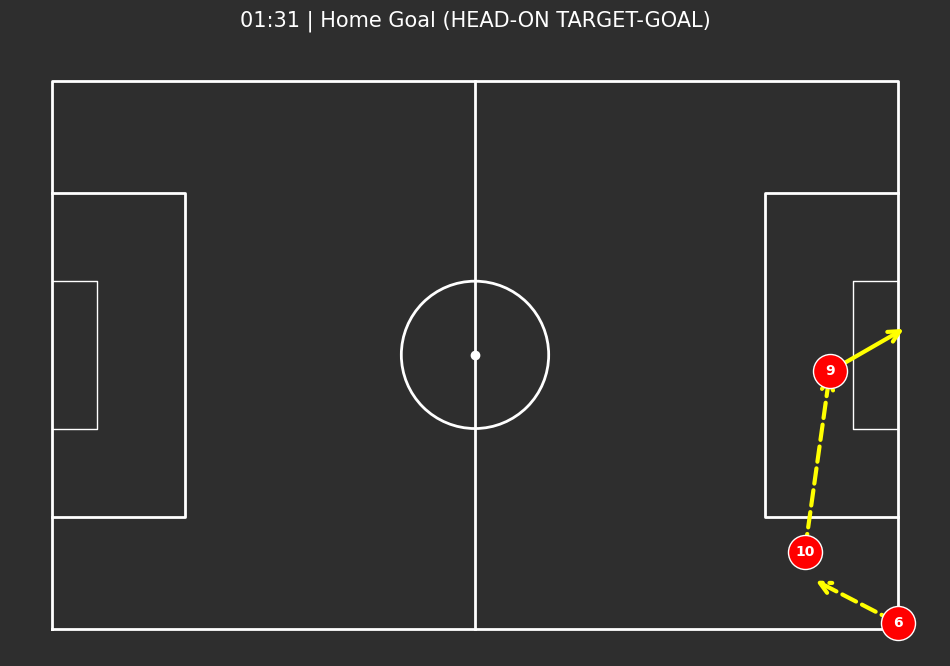

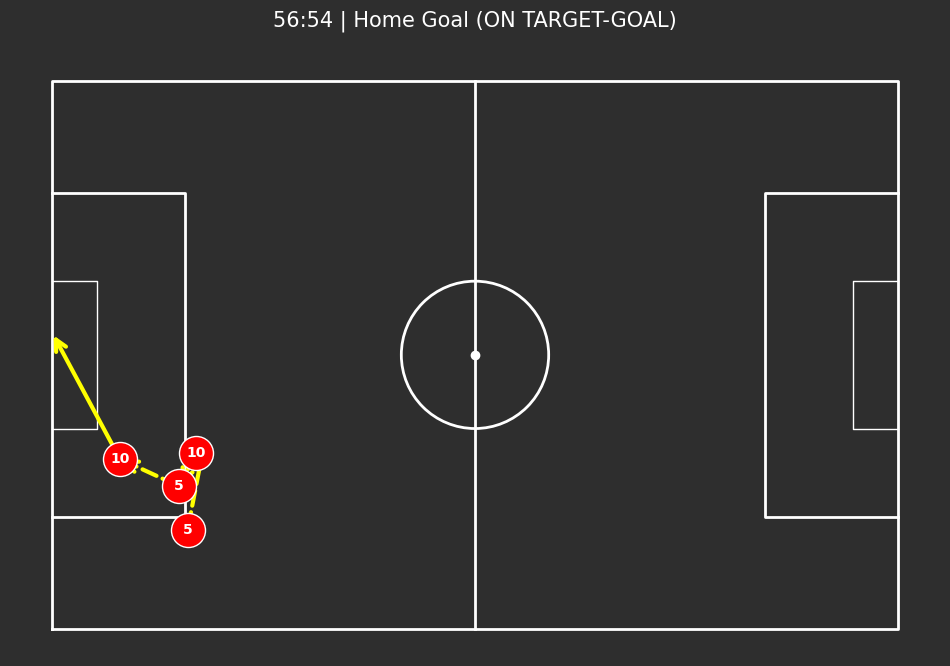

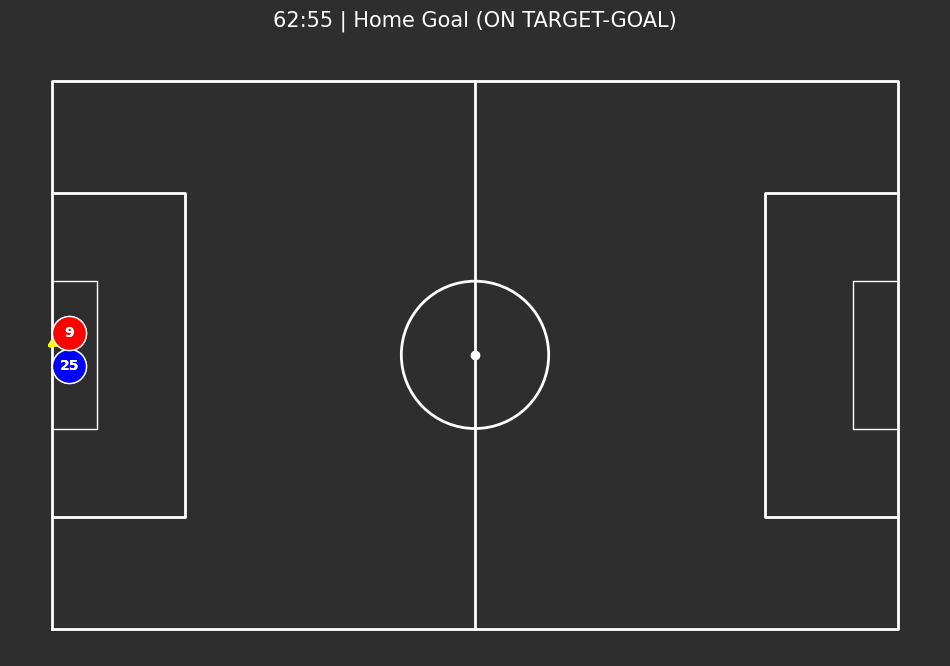

In [58]:
# Change this line:
goal_indices = df_events[(df_events['Type'] == 'SHOT') & 
                         (df_events['Subtype'].str.contains('-GOAL', na=False))].index.tolist()

for goal_idx in goal_indices:
    sequence = get_goal_sequence(goal_idx, df_events)
    plot_goal_sequence_final(sequence, df_events)